# Information frictions in the sequence space

In this notebook, we introduce information frictions in the sequence space.

### Package setup

General python packages:

In [1]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import sequence-space Jacobian.

In [2]:
import sequence_jacobian as sj

Now some commands to format plot output to look nice for slides.

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['axes.xmargin'] = 0
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=10)

Set the calibration for this notebook.

In [4]:
calibration = {'eis': 0.5,     # EIS
               'rho_e': 0.92,  # Persistence of idiosyncratic productivity shocks
               'sd_e': 0.92,   # Standard deviation of idiosyncratic productivity shocks
               'Y': 1.,        # Output
               'r_ante': 0.01, # target real interest rate
               'min_a': -1,    # Minimum asset level on the grid
               'max_a': 1_000, # Maximum asset level on the grid
               'n_a': 500,     # Number of asset grid points
               'n_e': 11}      # Number of productivity grid points

## Define blocks

Use the precoded 1-asset household side. 

In [5]:
hh = sj.hetblocks.hh_sim.hh
make_grids = sj.hetblocks.hh_sim.make_grids

def income(Y, e_grid):
    # post-tax labor income
    y = Y * e_grid
    return y

household_simple = hh.add_hetinputs([make_grids, income])

Set other blocks.

In [6]:
@sj.simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    return r

@sj.simple
def mkt_clearing_simple(A, Y, C):
    asset_mkt = A
    goods_mkt = C - Y
    return asset_mkt, goods_mkt

ha = sj.create_model([household_simple, ex_post_rate, mkt_clearing_simple])

Calibrate the model.

In [7]:
ss = ha.solve_steady_state(calibration, {'beta': (0.75, 0.9)}, ['asset_mkt'])

## Set up function to produce monetary plot

In [8]:
def plot_MP(Mr_list, M_list, filename='test', legend_list=None, color_list=['black','red','blue','brown','orange', 'green'],
            style_list=['solid']*6, rho=0.95, Tplot=70, Tfg=25):

    n = len(Mr_list)
    assert n == len(M_list)
    
    assert n <= 6  # need to add more colors and styles if larger
    
    # Solve IKC
    G = []
    
    for i in range(n):
        G.append(np.linalg.inv(np.identity(T) - M_list[i])@Mr_list[i])

    if legend_list is None:
        legend_list = [''] * n
    else:
        assert len(legend_list) == n
        
    # Shock
    
    dr = - 0.01*rho**np.arange(T)
    dr2 = - np.concatenate((np.zeros(Tfg),0.01*rho**np.arange(T-Tfg)))

    # Plot
    plt.figure(figsize=(8.3, 4))
    plt.subplot(1,2,1)
    for i in range(n):
        plt.plot(100*(G[i]@dr)[:Tplot], color=color_list[i], label=legend_list[i],linestyle=style_list[i])
    plt.axhline(y=0, color='#808080', linestyle=':')
    plt.xlabel('Quarters')
    plt.title('Response to $t=0$ rate cut')
    plt.subplot(1,2,2)
    for i in range(n):
        plt.plot(100*(G[i]@dr2)[:Tplot], color=color_list[i], label=legend_list[i],linestyle=style_list[i])
    plt.axhline(y=0, color='#808080', linestyle=':')
    plt.xlabel('Quarters')
    plt.title('Response to $t=' + str(Tfg) + '$ rate cut')
    plt.tight_layout()
    plt.legend(framealpha=0)
    # plt.savefig('figures/' + filename + '.pdf', format='pdf', transparent=True)
    plt.show()

# FIRE Jacobians

Let's begin by computing the full information rational expectations (FIRE) Jacobians of our household side.

In [9]:
T = 300
Js = ha.jacobian(ss, ['r_ante', 'Y'], ['C'], T=T)

M_ha = Js['C']['Y']  # this is the Jacobian of intertemporal MPCs
Mr_ha = Js['C']['r_ante']  # this is the Jacobian of consumption to interest rates

Now we plot the impulse responses of the FIRE model.

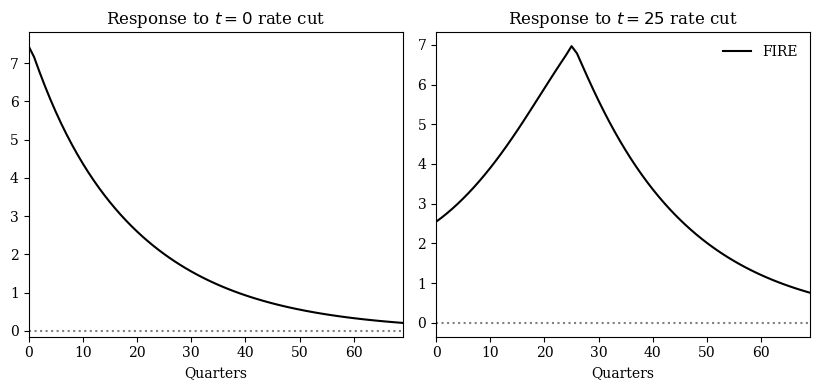

In [10]:
plot_MP([Mr_ha], [M_ha], 'HA_FIRE', legend_list=['FIRE'])

# Set up Jacobian manipulation functions

This function manipulates a FIRE Jacobian `M` with expectations matrix `E` to give the behavioral Jacobian `M_beh`.

In [11]:
from numba import njit
@njit
def manipulate_separable(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

Test this function.

In [12]:
# test with unit expectations matrix
M = np.random.rand(10, 10)
E = np.ones((10, 10))
manipulate_separable(M, E)
assert np.allclose(manipulate_separable(M, E), M)

# test with upper triangular expectations matrix
M = np.random.rand(10, 10)
E = np.tril(np.ones((10, 10)))
Mbeh = manipulate_separable(M, E)
for i in range(10):
    assert np.allclose(Mbeh[i:, i], M[:10-i, 0])

### Sticky expectations
Ok great, that seems to work well! Let's add functions that compute the specific expectations matrices.

In [13]:
def E_sticky_exp(theta, T=T, sticky_info=False):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    if sticky_info:
        return E
    else:
        E = np.triu(E, +1) + np.tril(np.ones((T, T)))
        return E

Simple test:

In [14]:
E_sticky_exp(0.5)[:5, :5]

array([[1.    , 0.5   , 0.5   , 0.5   , 0.5   ],
       [1.    , 1.    , 0.75  , 0.75  , 0.75  ],
       [1.    , 1.    , 1.    , 0.875 , 0.875 ],
       [1.    , 1.    , 1.    , 1.    , 0.9375],
       [1.    , 1.    , 1.    , 1.    , 1.    ]])

### Dispersed information

Great, let's move on to dispersed information. Here, the inputs are the precisions $\tau_j$.

In [15]:
def E_dispersed_exog(taus, T=T, sticky_info=False):
    assert taus.shape == (T,)  # these are tau_j / tau_eps
    col = np.cumsum(taus) / (np.cumsum(taus) + 1)
    E = np.tile(col[:, np.newaxis], (1, T))
    if sticky_info:
        return E
    else:
        E = np.triu(E, +1) + np.tril(np.ones((T, T)))
        return E

In [16]:
E_dispersed_exog(np.ones(T)*1)[:5, :5]

array([[1.        , 0.5       , 0.5       , 0.5       , 0.5       ],
       [1.        , 1.        , 0.66666667, 0.66666667, 0.66666667],
       [1.        , 1.        , 1.        , 0.75      , 0.75      ],
       [1.        , 1.        , 1.        , 1.        , 0.8       ],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

Looking great again!

### Cognitive discounting

Let's move on to cognitive discounting

In [17]:
def E_cog_disc(theta, T=T):
    E = np.ones((T, T))
    for t in range(T):
        E[t,t:] = theta**np.arange(T-t)
    return E

In [18]:
E_cog_disc(0.5)[:5, :5]

array([[1.    , 0.5   , 0.25  , 0.125 , 0.0625],
       [1.    , 1.    , 0.5   , 0.25  , 0.125 ],
       [1.    , 1.    , 1.    , 0.5   , 0.25  ],
       [1.    , 1.    , 1.    , 1.    , 0.5   ],
       [1.    , 1.    , 1.    , 1.    , 1.    ]])

In [19]:
assert np.allclose(E_cog_disc(0), E_sticky_exp(1))

### Level $k$ thinking

Finally, let's deal with level $k$ thinking.

In [20]:
def level_k(M, k_max=1, T=T):
    # first construct the level k = 1 matrix and solution
    M1 = manipulate_separable(M, E_cog_disc(0, T=T))
    G1 = np.linalg.inv(np.eye(T) - M1)
    
    # now iterate
    G_list = [G1]
    M_list = [M1]
    for i in range(k_max-1):
        G_k = G_list[-1]
        partialY_kplus1 = np.eye(T) + (M - M1) @ G_k
        G_kplus1 =  np.linalg.solve(np.eye(T) - M1, partialY_kplus1)
        M_effective = np.eye(T) - np.linalg.solve(partialY_kplus1, np.eye(T) - M1)
        G_list.append(G_kplus1)
        M_list.append(M_effective)
    M_list.reverse()
    return M_list

# Applying information frictions to monetary policy in HANK

Now all we're going to do is to apply the above Jacobian manipulation functions to the above FIRE Jacobians to obtain the effects of surprise and anticipated monetary policy shocks in HANK models with various information frictions.

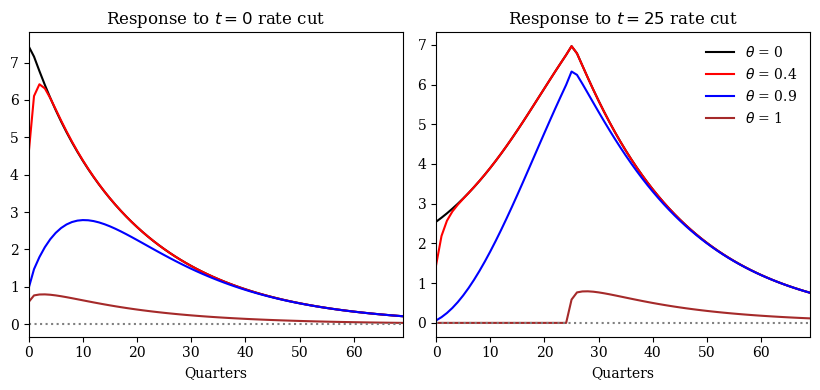

In [21]:
# Sticky expectations
thetas = [0, 0.4, 0.9, 1]
M_list = [manipulate_separable(M_ha, E_sticky_exp(theta)) for theta in thetas]
Mr_list = [manipulate_separable(Mr_ha, E_sticky_exp(theta)) for theta in thetas] #[Mr_ha] * len(M_list)
legend_list = ['$\\theta$ = '+str(theta) for theta in thetas]
plot_MP(Mr_list, M_list, filename='sticky_exp', legend_list=legend_list)

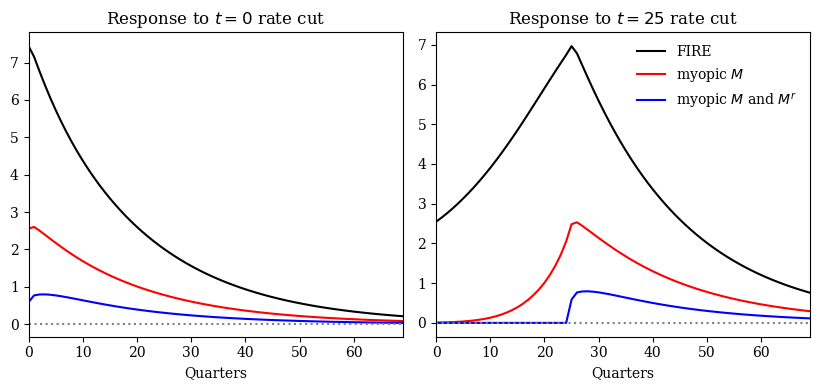

In [22]:
# Full vs no sticky expectations
thetas = [0, 1]
M_list = [manipulate_separable(M_ha, E_sticky_exp(theta)) for theta in thetas + [1]]
Mr_list = [Mr_ha] + [manipulate_separable(Mr_ha, E_sticky_exp(theta)) for theta in thetas] #[Mr_ha] * len(M_list)
legend_list = ['FIRE', 'myopic $M$', 'myopic $M$ and $M^r$']  # ['$\\theta$ = '+str(theta) for theta in thetas]
plot_MP(Mr_list, M_list, filename='full_sticky_exp', legend_list=legend_list)

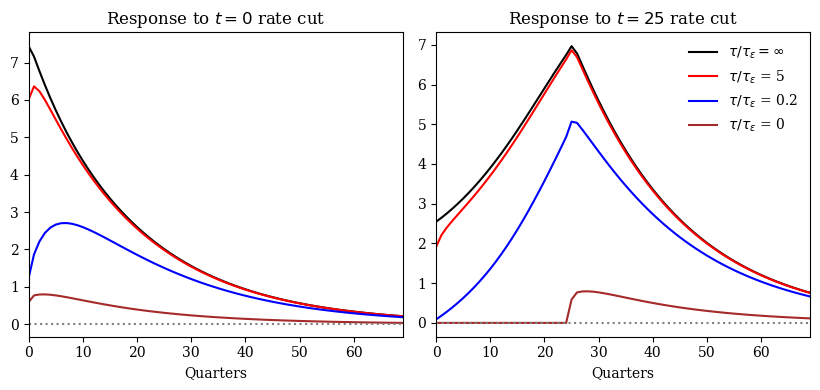

In [23]:
# Dispersed information
taus = [1e10, 5, 0.2, 0]  # constant for all j
M_list = [manipulate_separable(M_ha, E_dispersed_exog(np.ones(T)*tau)) for tau in taus]
Mr_list = [manipulate_separable(Mr_ha, E_dispersed_exog(np.ones(T)*tau)) for tau in taus] #[Mr_ha] * len(M_list)
legend_list = ['$\\tau / \\tau_\\epsilon = \\infty $'] + ['$\\tau / \\tau_\\epsilon $ = '+str(tau) for tau in taus[1:]]
plot_MP(Mr_list, M_list, filename='dispersed_info', legend_list=legend_list)

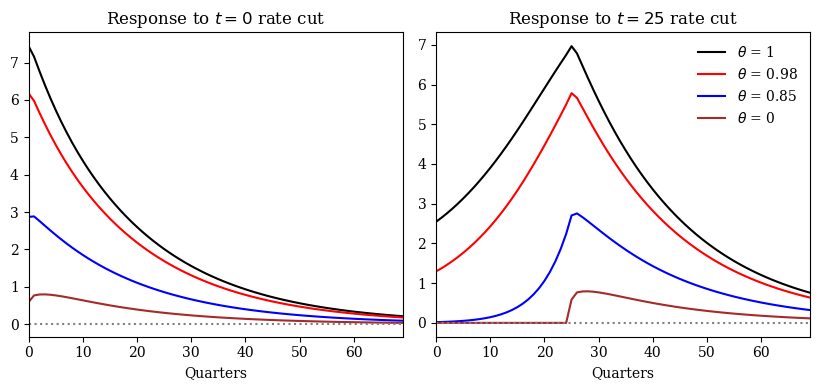

In [24]:
# Cognitive discounting
thetas = [1, 0.98, 0.85, 0]
M_list = [manipulate_separable(M_ha, E_cog_disc(theta)) for theta in thetas]
Mr_list = [manipulate_separable(Mr_ha, E_cog_disc(theta)) for theta in thetas] #[Mr_ha] * len(M_list)
legend_list = ['$\\theta$ = '+str(theta) for theta in thetas]
plot_MP(Mr_list, M_list, filename='cog_disc', legend_list=legend_list)

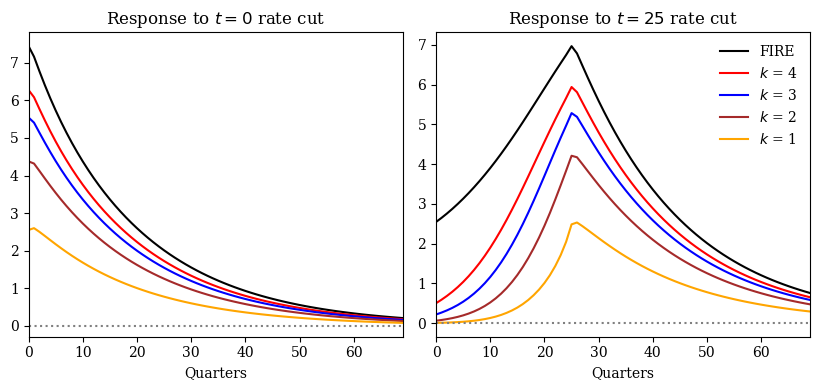

In [25]:
# Level k thinking
k_max = 4
M_list = [M_ha] + level_k(M_ha, k_max=k_max)
Mr_list = [Mr_ha] * len(M_list)
legend_list = ['FIRE'] + ['$k$ = '+str(k) for k in range(k_max, 0, -1)]
plot_MP(Mr_list, M_list, filename='level_k', legend_list=legend_list)